In [ ]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "space_data.json"
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"

PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path: {DATA_PATH}")

Project Root: c:\Users\samol\Desktop\space_objects_recognition
Data Path: c:\Users\samol\Desktop\space_objects_recognition\data\raw\space_data.json


In [9]:
# load JSON
try:
    df = pd.read_json(DATA_PATH)
except ValueError:
    with open(DATA_PATH, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)

print(f"Loaded {len(df)} records.")
df.head(5)

Loaded 2921 records.


,copyright,date,explanation,hdurl,media_type,service_version,title,url
0,José J. Chambó,2016-01-01,"A new year's treat for binoculars, as 2016 beg...",https://apod.nasa.gov/apod/image/1601/2013US10...,image,v1,Comet Catalina Tails,https://apod.nasa.gov/apod/image/1601/2013US10...
1,Gill Fry,2016-01-02,Triggered by the impact of a coronal mass ejec...,https://apod.nasa.gov/apod/image/1601/AuroraAu...,image,v1,Sky Lights in the New Year,https://apod.nasa.gov/apod/image/1601/AuroraAu...
2,NaN,2016-01-03,"On some nights, the sky is the best show in to...",https://apod.nasa.gov/apod/image/1601/aurora_v...,image,v1,A Starry Night of Iceland,https://apod.nasa.gov/apod/image/1601/aurora_v...
3,NaN,2016-01-04,"On the Moon, the Earth never rises -- or sets....",https://apod.nasa.gov/apod/image/1601/Earthris...,image,v1,Earthset from the Lunar Reconnaissance Orbiter,https://apod.nasa.gov/apod/image/1601/Earthris...
4,\nJohn Nemcik\n,2016-01-05,The majestic Lagoon Nebula is filled with hot ...,https://apod.nasa.gov/apod/image/1601/LagoonHS...,image,v1,"The Lagoon Nebula in Hydrogen, Sulfur, and Oxygen",https://apod.nasa.gov/apod/image/1601/LagoonHS...


In [10]:
KEYWORDS_MAP = {
    "Galaxy": [
        "galaxy", "galaxies", "spiral", "elliptical", "milky way", "andromeda", 
        "hubble deep field", "interacting group", "merging"
    ],
    "Nebula": [
        "nebula", "nebulae", "supernova remnant", "planetary nebula", "pillars of creation", 
        "orion", "crab", "cloud of gas", "dust"
    ],
    "Planet": [
        "planet", "planetary", "mars", "jupiter", "saturn", "venus", "mercury", 
        "uranus", "neptune", "pluto", "earth", "rover", "martian"
    ],
    "Star": [
        "star", "stars", "sun", "solar", "sunspot", "cluster", "globular", 
        "stellar", "binary"
    ],
    "Asteroid_Comet": [
        "asteroid", "comet", "meteor", "meteorite", "fireball", "comets", "asteroids"
    ]
}

def get_category(row):
    """
    The function checks the title and keywords of the post
    and returns the corresponding category.
    """
    # Title + Keywords
    title = str(row.get('title', '')).lower()
    
    keywords_raw = row.get('keywords', [])
    if isinstance(keywords_raw, list):
        keywords = " ".join(keywords_raw).lower()
    else:
        keywords = str(keywords_raw).lower()
    
    full_text = title + " " + keywords # + " " + explanation
    
    for category, tags in KEYWORDS_MAP.items():
        for tag in tags:
            if tag in full_text:
                return category
                
    return "Other"

df['label'] = df.apply(get_category, axis=1)

print("Labeling end!")
print(df['label'].value_counts())

Labeling end!
label
Other             1133
Planet             480
Nebula             428
Galaxy             393
Star               352
Asteroid_Comet     135
Name: count, dtype: int64


C:\Users\samol\AppData\Local\Temp\ipykernel_15092\3986191588.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette='viridis')


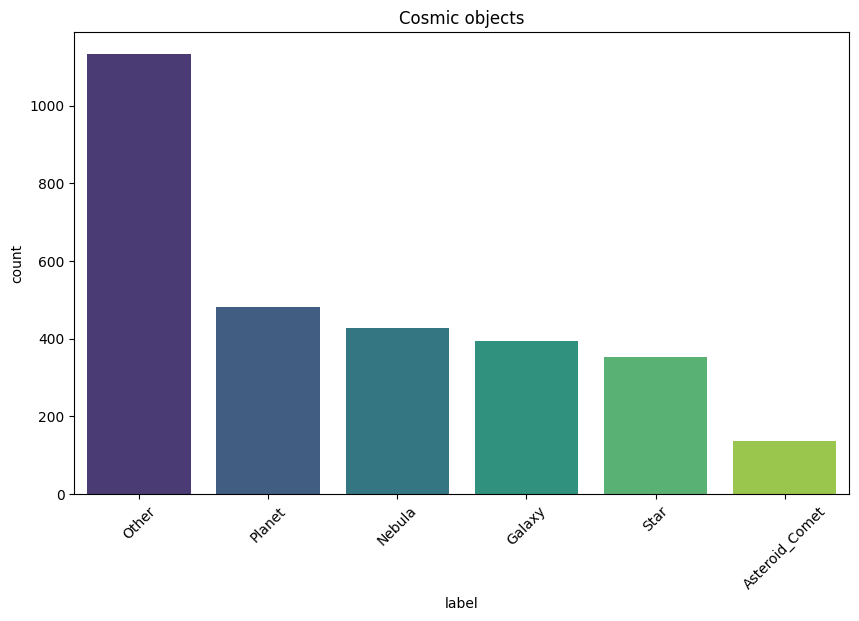

Records before: 2921
Left for learning: 1788
Columns: ['title', 'explanation', 'label', 'url', 'date']
Saved file: c:\Users\samol\Desktop\space_objects_recognition\data\processed\labeled_nasa_data.csv


In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette='viridis', hue='label', legend=False)
plt.title("Cosmic objects")
plt.xticks(rotation=45)
plt.show()

# Filtration, no Other
TARGET_CLASSES = ["Galaxy", "Nebula", "Planet", "Star", "Asteroid_Comet"]
df_clean = df[df['label'].isin(TARGET_CLASSES)].copy()

# Delete recird with empty "explanation"
df_clean = df_clean[df_clean['explanation'].notna() & (df_clean['explanation'] != "")]

print(f"Records before: {len(df)}")
print(f"Left for learning: {len(df_clean)}")

# Saving
columns_to_keep = ['title', 'explanation', 'label', 'url', 'date']

existing_columns = [col for col in columns_to_keep if col in df_clean.columns]
df_final = df_clean[existing_columns].copy()

print("Columns:", df_final.columns.tolist())

SAVE_PATH = PROCESSED_PATH / "labeled_nasa_data.csv"
df_final.to_csv(SAVE_PATH, index=False)
print(f"Saved file: {SAVE_PATH}")